In [73]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs'

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
tf.__version__

'2.1.0'

In [14]:
BATCH_SIZE = 256
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 16

END_TOKEN = 0

## Load Data

In [5]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
# neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [6]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Create multitype SeqGan

In [40]:

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    i_noise = Input(batch_shape=(batch_size, hidden_dim), name='hidden_noise')

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm, tm = TimeLSTM1(hidden_dim,
                       name='time_lstm',
                       stateful=True, 
                       return_sequences=False,
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
    
    hm_with_noise = tf.concat([hm, i_noise], axis=1)
    tm_with_noise = tf.concat([tm, i_noise], axis=1)
    
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm_with_noise)
        
    time_delta_out = Dense(1,
                   activation='softplus', # linear
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm_with_noise)
    
    generator = Model(
        inputs=[i_et, i_ts, i_noise],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [47]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm, tm = TimeLSTM1(hidden_dim,
                       name='time_lstm',
                       stateful=True, 
                       return_sequences=False,
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

## test initial G and D

In [32]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

In [33]:
G0

In [34]:
init_token_index = tf.ones([BATCH_SIZE, 1, 1], dtype=tf.int32)
init_token_prefix = tf.squeeze(tf.one_hot(init_token_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
init_time_delta = tf.zeros([BATCH_SIZE, 1, 1], dtype=tf.float64)

noise=tf.random.normal(shape=[BATCH_SIZE, HIDDEN_DIM], mean=0.0, stddev=0.1, dtype=tf.float64)

In [51]:
token_logits, time_delta_out = G0([init_token_prefix, init_time_delta, noise])

In [48]:
D0 = build_D(
    batch_size = BATCH_SIZE,
    T=T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim = HIDDEN_DIM,
    dropout_rate=0.25
)

In [50]:
prob = D0([init_token_prefix, init_time_delta])
prob

<tf.Tensor: shape=(256, 1), dtype=float64, numpy=
array([[0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.5358846],
       [0.

## Define rollout and sequence generation

In [56]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [83]:
def rollout_from_prefix_gumbel(
        G, batch_size, prefix_et, prefix_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = prefix_et
    all_state_ts = prefix_ts
    
    l_prefix = prefix_et.shape[1]
    
    G.reset_states()

    for _ in range(L-l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        step_noise = tf.random.normal(shape=[batch_size, HIDDEN_DIM], mean=0.0, stddev=0.1, dtype=tf.float64)
        
        token_logits, time_delta_out = G([curr_state_et, curr_state_ts, step_noise])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    return all_state_et, all_state_ts


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_index = tf.ones([batch_size, 1, 1], dtype=tf.int32)
    init_token_prefix = tf.squeeze(tf.one_hot(init_token_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_delta = tf.zeros([batch_size, 1, 1], dtype=tf.float64)
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_prefix_gumbel(generator, batch_size, init_token_prefix, init_time_delta, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [142]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mse_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]
            
            step_noise = tf.random.normal(shape=[BATCH_SIZE, HIDDEN_DIM], mean=0.0, stddev=0.1, dtype=tf.float64)
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts, step_noise])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mse_losses = tf.keras.losses.MSE(target_ts, time_delta_out)
            time_mse_loss = tf.reduce_mean(time_mse_losses)
            step_time_mse_loss_list.append(time_mse_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mse_loss = tf.reduce_mean(step_time_mse_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mse_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mse loss:{}'.format(episode_time_mse_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [143]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [144]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [145]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1


1it [00:00,  1.27it/s]

token ce loss:1.7477264099131051
time mse loss:466.1688719547541
train loss:467.9165983646672
Training Step: 2


2it [00:01,  1.76it/s]

token ce loss:1.7447334212749372
time mse loss:475.7460601347634
train loss:477.49079355603834
Training Step: 3


3it [00:01,  2.02it/s]

token ce loss:1.7440211466244064
time mse loss:478.708232322622
train loss:480.4522534692464
Training Step: 4


4it [00:02,  2.16it/s]

token ce loss:1.7423646803409572
time mse loss:469.12018516428935
train loss:470.86254984463034
Training Step: 5


5it [00:02,  2.02it/s]

token ce loss:1.7413894686487494
time mse loss:465.74901800465767
train loss:467.49040747330645
Training Step: 6


6it [00:02,  2.14it/s]

token ce loss:1.7415569204769235
time mse loss:470.2252113414288
train loss:471.9667682619057
Training Step: 7


7it [00:03,  2.21it/s]

token ce loss:1.7374521035600066
time mse loss:479.82538652439536
train loss:481.5628386279554
Training Step: 8


8it [00:03,  2.27it/s]

token ce loss:1.7363607500050815
time mse loss:465.09744982251357
train loss:466.83381057251864
Training Step: 9


9it [00:04,  2.31it/s]

token ce loss:1.7355218975573075
time mse loss:471.6618865434019
train loss:473.3974084409592
Training Step: 10


10it [00:04,  2.34it/s]

token ce loss:1.7355473111980655
time mse loss:474.70825122975003
train loss:476.4437985409481
Training Step: 11


11it [00:05,  2.35it/s]

token ce loss:1.7318679061814783
time mse loss:470.1271692278776
train loss:471.85903713405907
Training Step: 12


12it [00:05,  2.17it/s]

token ce loss:1.7301992830759165
time mse loss:461.04754888436855
train loss:462.7777481674445
Training Step: 13


13it [00:06,  2.23it/s]

token ce loss:1.7276615799268562
time mse loss:471.863371489588
train loss:473.5910330695149
Training Step: 14


14it [00:06,  2.28it/s]

token ce loss:1.7259960014556248
time mse loss:478.28784373409843
train loss:480.01383973555403
Training Step: 15


15it [00:06,  2.31it/s]

token ce loss:1.7246113995814176
time mse loss:465.38239529552357
train loss:467.107006695105
Training Step: 16


16it [00:07,  2.34it/s]

token ce loss:1.7253295228136385
time mse loss:470.2655132411609
train loss:471.9908427639745
Training Step: 17


17it [00:07,  2.36it/s]

token ce loss:1.7220604756123
time mse loss:484.3557470715352
train loss:486.0778075471475
Training Step: 18


18it [00:08,  2.17it/s]

token ce loss:1.7181671975951527
time mse loss:476.03032041653523
train loss:477.7484876141304
Training Step: 19


19it [00:08,  2.23it/s]

token ce loss:1.7166935066486055
time mse loss:461.7089071761855
train loss:463.4256006828341
Training Step: 20


20it [00:09,  2.27it/s]

token ce loss:1.7184521574997766
time mse loss:468.30913478893154
train loss:470.0275869464313
Training Step: 21


21it [00:09,  2.31it/s]

token ce loss:1.717112673637623
time mse loss:478.6529672187222
train loss:480.37007989235985
Training Step: 22


22it [00:09,  2.33it/s]

token ce loss:1.7151550504304474
time mse loss:466.3826128087876
train loss:468.09776785921804
Training Step: 23


23it [00:10,  2.35it/s]

token ce loss:1.712567036401141
time mse loss:477.3529602782286
train loss:479.0655273146297
Training Step: 24


24it [00:10,  2.36it/s]

token ce loss:1.7103526813451517
time mse loss:466.21164786465533
train loss:467.9220005460005
Training Step: 25


25it [00:11,  2.37it/s]

token ce loss:1.7075644999730628
time mse loss:463.82957641125495
train loss:465.537140911228
Training Step: 26


26it [00:11,  2.16it/s]

token ce loss:1.7060218423944888
time mse loss:470.8985417879353
train loss:472.6045636303298
Training Step: 27


27it [00:12,  2.22it/s]

token ce loss:1.7048945763475278
time mse loss:470.4638106708593
train loss:472.16870524720684
Training Step: 28


28it [00:12,  2.27it/s]

token ce loss:1.6998489165052486
time mse loss:469.696438359376
train loss:471.3962872758812
Training Step: 29


29it [00:12,  2.31it/s]

token ce loss:1.703127062581651
time mse loss:478.0023602763516
train loss:479.70548733893327
Training Step: 30


30it [00:13,  2.34it/s]

token ce loss:1.7007536510548
time mse loss:481.2901248390819
train loss:482.9908784901367
Training Step: 31


31it [00:13,  2.35it/s]

token ce loss:1.6964185467428075
time mse loss:478.65230658148573
train loss:480.3487251282285
Training Step: 32


32it [00:14,  2.15it/s]

token ce loss:1.6915880231818783
time mse loss:469.30873808913185
train loss:471.0003261123137
Training Step: 33


33it [00:14,  2.22it/s]

token ce loss:1.6886741522544302
time mse loss:459.6403169153993
train loss:461.3289910676537
Training Step: 34


34it [00:15,  2.27it/s]

token ce loss:1.6885864793063028
time mse loss:470.4420316684711
train loss:472.1306181477774
Training Step: 35


35it [00:15,  2.31it/s]

token ce loss:1.682347964547639
time mse loss:462.31609352474425
train loss:463.9984414892919
Training Step: 36


36it [00:16,  2.32it/s]

token ce loss:1.6803805267945848
time mse loss:465.9872490498133
train loss:467.66762957660785
Training Step: 37


37it [00:16,  2.34it/s]

token ce loss:1.6781592852316394
time mse loss:469.29922697663113
train loss:470.97738626186276
Training Step: 38


38it [00:16,  2.36it/s]

token ce loss:1.6709992851297497
time mse loss:465.4081051602135
train loss:467.07910444534326
Training Step: 39


39it [00:17,  2.36it/s]

token ce loss:1.6723902683073852
time mse loss:463.83180544734694
train loss:465.5041957156543
Training Step: 40


40it [00:17,  2.17it/s]

token ce loss:1.6691743025695611
time mse loss:469.60519559454616
train loss:471.2743698971157
Training Step: 41


41it [00:18,  2.23it/s]

token ce loss:1.6604613258382082
time mse loss:455.4728008038478
train loss:457.133262129686
Training Step: 42


42it [00:18,  2.27it/s]

token ce loss:1.658767281331525
time mse loss:460.50353641476534
train loss:462.16230369609684
Training Step: 43


43it [00:19,  2.29it/s]

token ce loss:1.6559681019948762
time mse loss:476.402335078276
train loss:478.05830318027085
Training Step: 44


44it [00:19,  2.31it/s]

token ce loss:1.650003930882923
time mse loss:462.85446684369026
train loss:464.5044707745732
Training Step: 45


45it [00:19,  2.34it/s]

token ce loss:1.6437440465392334
time mse loss:462.2363651311418
train loss:463.880109177681
Training Step: 46


46it [00:20,  2.36it/s]

token ce loss:1.6389588655373024
time mse loss:454.8758084108511
train loss:456.5147672763884
Training Step: 47


47it [00:20,  2.17it/s]

token ce loss:1.630833508516762
time mse loss:459.65340064407854
train loss:461.28423415259533
Training Step: 48


48it [00:21,  2.23it/s]

token ce loss:1.623591086758082
time mse loss:460.32600307628474
train loss:461.94959416304283
Training Step: 49


49it [00:21,  2.27it/s]

token ce loss:1.6198197419258022
time mse loss:463.45961352820234
train loss:465.07943327012816
Training Step: 50


50it [00:22,  2.30it/s]

token ce loss:1.614769481015918
time mse loss:470.08075242548637
train loss:471.6955219065023
Training Step: 51


51it [00:22,  2.33it/s]

token ce loss:1.605449385230378
time mse loss:450.71018627299964
train loss:452.31563565823
Training Step: 52


52it [00:23,  2.34it/s]

token ce loss:1.601565614296281
time mse loss:461.9229437544501
train loss:463.5245093687464
Training Step: 53


53it [00:23,  2.34it/s]

token ce loss:1.5948444932619221
time mse loss:460.9836404914007
train loss:462.5784849846626
Training Step: 54


54it [00:23,  2.35it/s]

token ce loss:1.5860088666793029
time mse loss:460.110518973321
train loss:461.69652784000033
Training Step: 55


55it [00:24,  2.16it/s]

token ce loss:1.5864113046871509
time mse loss:454.39745899295514
train loss:455.9838702976423
Training Step: 56


56it [00:24,  2.22it/s]

token ce loss:1.5749167827158097
time mse loss:466.2197793625147
train loss:467.79469614523055
Training Step: 57


57it [00:25,  2.26it/s]

token ce loss:1.569422330299861
time mse loss:458.01342376504016
train loss:459.58284609534
Training Step: 58


58it [00:25,  2.30it/s]

token ce loss:1.558364638975135
time mse loss:461.87020282004033
train loss:463.4285674590155
Training Step: 59


59it [00:26,  2.31it/s]

token ce loss:1.553828971751536
time mse loss:446.9554639047278
train loss:448.5092928764794
Training Step: 60


60it [00:26,  2.33it/s]

token ce loss:1.5481632406951404
time mse loss:461.1054203492992
train loss:462.65358358999435
Training Step: 61


61it [00:27,  2.14it/s]

token ce loss:1.542916105270907
time mse loss:448.9650577215547
train loss:450.5079738268256
Training Step: 62


62it [00:27,  2.20it/s]

token ce loss:1.5356132659145005
time mse loss:445.7319693610751
train loss:447.26758262698957
Training Step: 63


63it [00:27,  2.25it/s]

token ce loss:1.5292223889635452
time mse loss:449.51557386738205
train loss:451.0447962563456
Training Step: 64


64it [00:28,  2.29it/s]

token ce loss:1.5248340062704049
time mse loss:452.0900178289727
train loss:453.6148518352431
Training Step: 65


65it [00:28,  2.31it/s]

token ce loss:1.5220531067226901
time mse loss:448.5865334285492
train loss:450.1085865352719
Training Step: 66


66it [00:29,  2.32it/s]

token ce loss:1.5164951887520273
time mse loss:456.09272600719015
train loss:457.60922119594215
Training Step: 67


67it [00:29,  2.35it/s]

token ce loss:1.5089731020853219
time mse loss:458.2817363750696
train loss:459.79070947715496
Training Step: 68


68it [00:30,  2.36it/s]

token ce loss:1.5063596938549124
time mse loss:445.63033270785735
train loss:447.13669240171225
Training Step: 69


69it [00:30,  2.17it/s]

token ce loss:1.500683894265515
time mse loss:445.9024238977587
train loss:447.40310779202423
Training Step: 70


70it [00:31,  2.23it/s]

token ce loss:1.496754475801163
time mse loss:444.02344591748005
train loss:445.5202003932812
Training Step: 71


71it [00:31,  2.27it/s]

token ce loss:1.4878402831451256
time mse loss:450.09138176205636
train loss:451.5792220452015
Training Step: 72


72it [00:31,  2.30it/s]

token ce loss:1.4937734113620853
time mse loss:461.152132404403
train loss:462.6459058157651
Training Step: 73


73it [00:32,  2.30it/s]

token ce loss:1.483498767125574
time mse loss:453.0581966118718
train loss:454.54169537899736
Training Step: 74


74it [00:32,  2.31it/s]

token ce loss:1.4809192517151841
time mse loss:445.1702414285037
train loss:446.6511606802189
Training Step: 75


75it [00:33,  2.33it/s]

token ce loss:1.4747393975495429
time mse loss:458.97137056728735
train loss:460.4461099648369
Training Step: 76


76it [00:33,  2.16it/s]

token ce loss:1.4733317070916958
time mse loss:442.82248165648815
train loss:444.29581336357984
Training Step: 77


77it [00:34,  2.22it/s]

token ce loss:1.4714202881989162
time mse loss:450.2613852716264
train loss:451.73280555982535
Training Step: 78


78it [00:34,  2.25it/s]

token ce loss:1.4656098683920522
time mse loss:445.60038073457633
train loss:447.0659906029684
Training Step: 79


79it [00:34,  2.27it/s]

token ce loss:1.462569752946511
time mse loss:452.9306292666861
train loss:454.3931990196326
Training Step: 80


80it [00:35,  2.30it/s]

token ce loss:1.4586027615571822
time mse loss:442.74628554927256
train loss:444.20488831082974
Training Step: 81


81it [00:35,  2.31it/s]

token ce loss:1.4578338142937795
time mse loss:446.30167916188964
train loss:447.75951297618343
Training Step: 82


82it [00:36,  2.31it/s]

token ce loss:1.453632913746866
time mse loss:444.4203796938142
train loss:445.87401260756104
Training Step: 83


83it [00:36,  2.32it/s]

token ce loss:1.4477930881567436
time mse loss:442.99404905063966
train loss:444.4418421387964
Training Step: 84


84it [00:37,  2.12it/s]

token ce loss:1.4422493247476127
time mse loss:440.32275933620656
train loss:441.76500866095415
Training Step: 85


85it [00:37,  2.19it/s]

token ce loss:1.4484491516927358
time mse loss:440.78824064277615
train loss:442.2366897944689
Training Step: 86


86it [00:38,  2.23it/s]

token ce loss:1.4411747727465685
time mse loss:440.3754059823024
train loss:441.816580755049
Training Step: 87


87it [00:38,  2.26it/s]

token ce loss:1.439179261768932
time mse loss:434.2002271483551
train loss:435.639406410124
Training Step: 88


88it [00:38,  2.29it/s]

token ce loss:1.4332774896642122
time mse loss:436.73251251150293
train loss:438.1657900011671
Training Step: 89


89it [00:39,  2.30it/s]

token ce loss:1.430549204072798
time mse loss:438.3067634287528
train loss:439.7373126328256
Training Step: 90


90it [00:39,  2.12it/s]

token ce loss:1.431646794131033
time mse loss:435.96707207339796
train loss:437.398718867529
Training Step: 91


91it [00:40,  2.18it/s]

token ce loss:1.4282445956076535
time mse loss:432.8378269140465
train loss:434.2660715096542
Training Step: 92


92it [00:40,  2.23it/s]

token ce loss:1.426547337850355
time mse loss:431.8485641879124
train loss:433.2751115257628
Training Step: 93


93it [00:41,  2.27it/s]

token ce loss:1.429603598017703
time mse loss:436.55957828500084
train loss:437.98918188301855
Training Step: 94


94it [00:41,  2.30it/s]

token ce loss:1.4170313099285239
time mse loss:442.5675501966869
train loss:443.9845815066154
Training Step: 95


95it [00:42,  2.32it/s]

token ce loss:1.4161761514807802
time mse loss:432.63646778850745
train loss:434.05264393998823
Training Step: 96


96it [00:42,  2.35it/s]

token ce loss:1.4128381600169473
time mse loss:424.08897609217127
train loss:425.50181425218824
Training Step: 97


97it [00:42,  2.35it/s]

token ce loss:1.4116010374349257
time mse loss:430.9735770589643
train loss:432.3851780963992
Training Step: 98


98it [00:43,  2.15it/s]

token ce loss:1.4097565740981781
time mse loss:434.7743638963795
train loss:436.1841204704777
Training Step: 99


99it [00:43,  2.22it/s]

token ce loss:1.407318657693662
time mse loss:436.4522239956729
train loss:437.8595426533666
Training Step: 100


100it [00:44,  2.26it/s]

token ce loss:1.404188631165133
time mse loss:428.7517344026031
train loss:430.15592303376826


100it [00:44,  2.25it/s]


In [150]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [151]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 6)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      112         event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_63 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

### pre-train D

In [152]:
N_fake_D = N_real_D = N_total_G // 2

In [153]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [154]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [155]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [156]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [157]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
total discriminator loss:0.6890776943826158


2it [00:00,  3.12it/s]

Training Step: 2
total discriminator loss:0.692735757166364
Training Step: 3


3it [00:00,  3.89it/s]

total discriminator loss:0.6815093749014393
Training Step: 4
total discriminator loss:0.6843269043307428


5it [00:01,  4.79it/s]

Training Step: 5
total discriminator loss:0.683640533724807
Training Step: 6


6it [00:01,  5.01it/s]

total discriminator loss:0.6895141045190103
Training Step: 7
total discriminator loss:0.6825861045769128


8it [00:01,  5.25it/s]

Training Step: 8
total discriminator loss:0.6803490802912955
Training Step: 9


9it [00:01,  5.31it/s]

total discriminator loss:0.6841603150966515
Training Step: 10
total discriminator loss:0.6847384781117478


10it [00:02,  5.35it/s]

Training Step: 11


11it [00:02,  4.22it/s]

total discriminator loss:0.6823723610428156
Training Step: 12
total discriminator loss:0.6783211534844649


13it [00:02,  4.76it/s]

Training Step: 13
total discriminator loss:0.6771725383816039
Training Step: 14


14it [00:03,  4.95it/s]

total discriminator loss:0.6743567108047106
Training Step: 15
total discriminator loss:0.6787685007789926


16it [00:03,  5.18it/s]

Training Step: 16
total discriminator loss:0.6754372975344873
Training Step: 17


17it [00:03,  5.23it/s]

total discriminator loss:0.6729704614282511
Training Step: 18
total discriminator loss:0.673159350507511


19it [00:03,  5.29it/s]

Training Step: 19
total discriminator loss:0.6712844905227691
Training Step: 20


20it [00:04,  5.33it/s]

total discriminator loss:0.6678859938030823
Training Step: 21
total discriminator loss:0.667199627265458


22it [00:04,  5.35it/s]

Training Step: 22
total discriminator loss:0.6648399523472504
Training Step: 23


23it [00:04,  5.27it/s]

total discriminator loss:0.663045575226092
Training Step: 24
total discriminator loss:0.6628346695100629


25it [00:05,  5.29it/s]

Training Step: 25
total discriminator loss:0.6591226927236333
Training Step: 26


26it [00:05,  5.29it/s]

total discriminator loss:0.6565285126847547
Training Step: 27
total discriminator loss:0.6546593097878901


28it [00:05,  5.31it/s]

Training Step: 28
total discriminator loss:0.6514904768134191
Training Step: 29


29it [00:05,  5.28it/s]

total discriminator loss:0.6490997965289107
Training Step: 30
total discriminator loss:0.6465601180824737


31it [00:06,  5.30it/s]

Training Step: 31
total discriminator loss:0.6428905038448458
Training Step: 32


32it [00:06,  5.30it/s]

total discriminator loss:0.6411634666356558
Training Step: 33
total discriminator loss:0.6350259259616466


34it [00:06,  5.32it/s]

Training Step: 34
total discriminator loss:0.6304604722644863
Training Step: 35


35it [00:06,  5.36it/s]

total discriminator loss:0.6266906529902585
Training Step: 36


36it [00:07,  4.38it/s]

total discriminator loss:0.6209705985868744
Training Step: 37
total discriminator loss:0.6179276318535332


38it [00:07,  4.81it/s]

Training Step: 38
total discriminator loss:0.6128626081453947
Training Step: 39


39it [00:07,  4.92it/s]

total discriminator loss:0.6090893780514827
Training Step: 40
total discriminator loss:0.6006954676964209


41it [00:08,  5.16it/s]

Training Step: 41
total discriminator loss:0.5965479046334099
Training Step: 42


42it [00:08,  5.21it/s]

total discriminator loss:0.59047802513449
Training Step: 43
total discriminator loss:0.5826315334272567


44it [00:08,  5.27it/s]

Training Step: 44
total discriminator loss:0.5753131326688982
Training Step: 45


45it [00:09,  5.28it/s]

total discriminator loss:0.5671296044175147
Training Step: 46
total discriminator loss:0.5522968203507632


47it [00:09,  5.33it/s]

Training Step: 47
total discriminator loss:0.5436842827402679
Training Step: 48


48it [00:09,  5.35it/s]

total discriminator loss:0.5433201687631157
Training Step: 49
total discriminator loss:0.5277861594470765


50it [00:09,  5.33it/s]

Training Step: 50
total discriminator loss:0.5221563066212274
Training Step: 51


51it [00:10,  5.33it/s]

total discriminator loss:0.5088051106797862
Training Step: 52
total discriminator loss:0.49993171404498593


53it [00:10,  5.35it/s]

Training Step: 53
total discriminator loss:0.4936560170863519
Training Step: 54


54it [00:10,  5.33it/s]

total discriminator loss:0.49012307970344104
Training Step: 55
total discriminator loss:0.4844646716978618


56it [00:11,  5.35it/s]

Training Step: 56
total discriminator loss:0.4806448714033758
Training Step: 57


57it [00:11,  5.35it/s]

total discriminator loss:0.4777729045096385
Training Step: 58
total discriminator loss:0.46255037372364705


59it [00:11,  5.33it/s]

Training Step: 59
total discriminator loss:0.46125555284792347
Training Step: 60


60it [00:11,  5.24it/s]

total discriminator loss:0.45222843828910253
Training Step: 61
total discriminator loss:0.4500224809273781


61it [00:12,  5.27it/s]

Training Step: 62


62it [00:12,  4.27it/s]

total discriminator loss:0.4361164290715174
Training Step: 63
total discriminator loss:0.4232212263029853


64it [00:12,  4.65it/s]

Training Step: 64
total discriminator loss:0.4284048556006298
Training Step: 65


65it [00:12,  4.75it/s]

total discriminator loss:0.4143117205455134
Training Step: 66
total discriminator loss:0.4009724683644499


67it [00:13,  4.93it/s]

Training Step: 67
total discriminator loss:0.3937774826035713
Training Step: 68


68it [00:13,  5.01it/s]

total discriminator loss:0.3858597248497665
Training Step: 69
total discriminator loss:0.3863191845416716


70it [00:13,  5.12it/s]

Training Step: 70
total discriminator loss:0.38768824071063546
Training Step: 71


71it [00:14,  5.18it/s]

total discriminator loss:0.38839192628159913
Training Step: 72
total discriminator loss:0.3886259740594674


73it [00:14,  5.24it/s]

Training Step: 73
total discriminator loss:0.3800717269512947
Training Step: 74


74it [00:14,  5.25it/s]

total discriminator loss:0.39109252550990503
Training Step: 75
total discriminator loss:0.3895262528223322


76it [00:15,  5.22it/s]

Training Step: 76
total discriminator loss:0.36908583620718344
Training Step: 77


77it [00:15,  5.24it/s]

total discriminator loss:0.37845722333308984
Training Step: 78
total discriminator loss:0.38709763596123714


79it [00:15,  5.27it/s]

Training Step: 79
total discriminator loss:0.4047044962858436
Training Step: 80


80it [00:15,  5.27it/s]

total discriminator loss:0.4101236149100775
Training Step: 81
total discriminator loss:0.41644230169754715


82it [00:16,  5.29it/s]

Training Step: 82
total discriminator loss:0.3771385526991453
Training Step: 83


83it [00:16,  5.27it/s]

total discriminator loss:0.3841131298500494
Training Step: 84
total discriminator loss:0.3692121987406884


85it [00:16,  5.28it/s]

Training Step: 85
total discriminator loss:0.36153186020959194
Training Step: 86


86it [00:16,  5.31it/s]

total discriminator loss:0.36796956134622
Training Step: 87
total discriminator loss:0.374627741639752


88it [00:17,  5.33it/s]

Training Step: 88
total discriminator loss:0.36597908047351513
Training Step: 89


89it [00:17,  4.40it/s]

total discriminator loss:0.3578137240481725
Training Step: 90
total discriminator loss:0.36025751691845315


91it [00:18,  4.82it/s]

Training Step: 91
total discriminator loss:0.3379778392296903
Training Step: 92


92it [00:18,  4.96it/s]

total discriminator loss:0.33453108487055205
Training Step: 93
total discriminator loss:0.3154650633112791


94it [00:18,  5.11it/s]

Training Step: 94
total discriminator loss:0.31790629243867974
Training Step: 95


95it [00:18,  5.15it/s]

total discriminator loss:0.31510898733450726
Training Step: 96
total discriminator loss:0.3127435862516952


97it [00:19,  5.23it/s]

Training Step: 97
total discriminator loss:0.3042343162319759
Training Step: 98


98it [00:19,  5.26it/s]

total discriminator loss:0.3015667818804445
Training Step: 99
total discriminator loss:0.3036764912743922


100it [00:19,  5.28it/s]

Training Step: 100
total discriminator loss:0.2833421220417538


100it [00:19,  5.03it/s]


In [159]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [160]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 6)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      112         event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_67 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

## Gumbel  Traning

In [167]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [168]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 6)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      112         event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_72 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [169]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

In [170]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())

0it [00:00, ?it/s]

Training Step: 1
generator loss:1.0510841162965103
-----------------------


1it [00:01,  1.42s/it]

total discriminator loss:0.35805379997320397
average true return:0.554798941822021
-----------------------
Training Step: 2
generator loss:1.2671331859094122
-----------------------


2it [00:02,  1.18s/it]

total discriminator loss:0.3607415072589883
average true return:0.5284976827562917
-----------------------
Training Step: 3
generator loss:1.4468470434143725
-----------------------


3it [00:03,  1.18s/it]

total discriminator loss:0.3653486116201786
average true return:0.5179288955941111
-----------------------
Training Step: 4
generator loss:1.5326956438936308
-----------------------


4it [00:04,  1.12s/it]

total discriminator loss:0.3245841807430946
average true return:0.5062767445462253
-----------------------
Training Step: 5
generator loss:1.5845799320204268
-----------------------


5it [00:05,  1.09s/it]

total discriminator loss:0.3401552730343198
average true return:0.5004328894797614
-----------------------
Training Step: 6
generator loss:1.637062816189884
-----------------------


6it [00:06,  1.08s/it]

total discriminator loss:1.5492425430406471
average true return:0.4935092648545836
-----------------------
Training Step: 7
generator loss:1.6619902812001417
-----------------------


7it [00:07,  1.12s/it]

total discriminator loss:0.36523070480253583
average true return:0.4867366210500341
-----------------------
Training Step: 8
generator loss:1.6790290146612976
-----------------------


8it [00:08,  1.10s/it]

total discriminator loss:0.3653744205096251
average true return:0.4808555164608638
-----------------------
Training Step: 9
generator loss:1.685658882237794
-----------------------


9it [00:10,  1.09s/it]

total discriminator loss:0.3735588994048117
average true return:0.47108766011407766
-----------------------
Training Step: 10
generator loss:1.6882606295272629
-----------------------


10it [00:11,  1.07s/it]

total discriminator loss:0.3673825222149455
average true return:0.46418986322414374
-----------------------
Training Step: 11
generator loss:1.6897740455230066
-----------------------


11it [00:12,  1.11s/it]

total discriminator loss:0.36176513567857166
average true return:0.4623096527569984
-----------------------
Training Step: 12
generator loss:1.6915597485239011
-----------------------


12it [00:13,  1.09s/it]

total discriminator loss:0.3705536895734103
average true return:0.46437505965231385
-----------------------
Training Step: 13
generator loss:1.6913636059997041
-----------------------


13it [00:14,  1.08s/it]

total discriminator loss:0.3661908069105334
average true return:0.46453298596236287
-----------------------
Training Step: 14
generator loss:1.6888275818534724
-----------------------


14it [00:15,  1.12s/it]

total discriminator loss:0.3579870941348388
average true return:0.4684477403446317
-----------------------
Training Step: 15
generator loss:1.6817593662621038
-----------------------


15it [00:16,  1.10s/it]

total discriminator loss:0.3640142947778483
average true return:0.46498574441271123
-----------------------
Training Step: 16
generator loss:1.6771771597269853
-----------------------


16it [00:17,  1.08s/it]

total discriminator loss:0.3654435779690472
average true return:0.47323502468744955
-----------------------
Training Step: 17
generator loss:1.6712485325886832
-----------------------


17it [00:18,  1.07s/it]

total discriminator loss:0.36482644056077396
average true return:0.47225376010349907
-----------------------
Training Step: 18
generator loss:1.6670828216698077
-----------------------


18it [00:19,  1.06s/it]

total discriminator loss:0.3730203465566807
average true return:0.47640015066207464
-----------------------
Training Step: 19
generator loss:1.6619005001095557
-----------------------


19it [00:20,  1.10s/it]

total discriminator loss:0.35503780621942527
average true return:0.4788738902570921
-----------------------
Training Step: 20
generator loss:1.6584112316599695
-----------------------


20it [00:22,  1.08s/it]

total discriminator loss:0.36637800146776967
average true return:0.4777581766509695
-----------------------
Training Step: 21
generator loss:1.6542244476125028
-----------------------


21it [00:23,  1.07s/it]

total discriminator loss:0.3372743374824425
average true return:0.48655029037244985
-----------------------
Training Step: 22
generator loss:1.6457088240345876
-----------------------


22it [00:24,  1.07s/it]

total discriminator loss:0.34957202935721854
average true return:0.4892343901540014
-----------------------
Training Step: 23
generator loss:1.636117679001701
-----------------------


23it [00:25,  1.11s/it]

total discriminator loss:0.36478446698128464
average true return:0.4936172711290468
-----------------------
Training Step: 24
generator loss:1.6344792007337614
-----------------------


24it [00:26,  1.09s/it]

total discriminator loss:0.3544273799051934
average true return:0.4908110077588439
-----------------------
Training Step: 25
generator loss:1.624326762087023
-----------------------


25it [00:27,  1.08s/it]

total discriminator loss:0.3648236620508486
average true return:0.4921717047598558
-----------------------
Training Step: 26
generator loss:1.621378381494595
-----------------------


26it [00:28,  1.07s/it]

total discriminator loss:0.3470113226972842
average true return:0.49712712006160564
-----------------------
Training Step: 27
generator loss:1.6139925426184223
-----------------------


27it [00:29,  1.11s/it]

total discriminator loss:0.3476199380132639
average true return:0.4962818017782519
-----------------------
Training Step: 28
generator loss:1.6094524949698634
-----------------------


28it [00:30,  1.09s/it]

total discriminator loss:0.3405125662073902
average true return:0.49764787141802713
-----------------------
Training Step: 29
generator loss:1.6088126424899847
-----------------------


29it [00:31,  1.08s/it]

total discriminator loss:0.33456918939672875
average true return:0.49342006386095705
-----------------------
Training Step: 30
generator loss:1.6030677586735584
-----------------------


30it [00:32,  1.07s/it]

total discriminator loss:0.3463830265776569
average true return:0.4951363233779371
-----------------------
Training Step: 31
generator loss:1.591244862489035
-----------------------


31it [00:34,  1.11s/it]

total discriminator loss:0.3647329555872575
average true return:0.49521025933824836
-----------------------
Training Step: 32
generator loss:1.5821338276208559
-----------------------


32it [00:35,  1.09s/it]

total discriminator loss:0.3406238507021392
average true return:0.4991483611892278
-----------------------
Training Step: 33
generator loss:1.5757121743833422
-----------------------


33it [00:36,  1.08s/it]

total discriminator loss:0.3418210089196301
average true return:0.4976135899030754
-----------------------
Training Step: 34
generator loss:1.5500201707138666
-----------------------


34it [00:37,  1.11s/it]

total discriminator loss:0.35664048181902136
average true return:0.5023636653117498
-----------------------
Training Step: 35
generator loss:1.534348151152766
-----------------------


35it [00:38,  1.10s/it]

total discriminator loss:0.33672422508349587
average true return:0.5003340715081959
-----------------------
Training Step: 36
generator loss:1.5169271953815728
-----------------------


36it [00:39,  1.08s/it]

total discriminator loss:0.3235212085874803
average true return:0.4990378375295246
-----------------------
Training Step: 37
generator loss:1.5102062396586884
-----------------------


37it [00:40,  1.08s/it]

total discriminator loss:0.3411965524568027
average true return:0.5027232386054685
-----------------------
Training Step: 38
generator loss:1.4988620954366398
-----------------------


38it [00:41,  1.07s/it]

total discriminator loss:0.35695223513543217
average true return:0.5009484315132234
-----------------------
Training Step: 39
generator loss:1.496541309099301
-----------------------


39it [00:42,  1.11s/it]

total discriminator loss:0.3572620883666889
average true return:0.4977753796617197
-----------------------
Training Step: 40
generator loss:1.4918505339105121
-----------------------


40it [00:43,  1.10s/it]

total discriminator loss:0.33703484433729575
average true return:0.49809507875698233
-----------------------
Training Step: 41
generator loss:1.4892542232314545
-----------------------


41it [00:44,  1.09s/it]

total discriminator loss:0.34702822102800734
average true return:0.49869230835460376
-----------------------
Training Step: 42
generator loss:1.486788938844592
-----------------------


42it [00:45,  1.09s/it]

total discriminator loss:0.3169854343715386
average true return:0.497856646978776
-----------------------
Training Step: 43
generator loss:1.4788682030875424
-----------------------


43it [00:47,  1.14s/it]

total discriminator loss:0.33560311534257836
average true return:0.4966452120275259
-----------------------
Training Step: 44
generator loss:1.4773430057815977
-----------------------


44it [00:48,  1.12s/it]

total discriminator loss:0.33698758553542546
average true return:0.5001815951936162
-----------------------
Training Step: 45
generator loss:1.4764211436845058
-----------------------


45it [00:49,  1.11s/it]

total discriminator loss:0.3480092928923334
average true return:0.5011782331717798
-----------------------
Training Step: 46
generator loss:1.4623160726892932
-----------------------


46it [00:50,  1.10s/it]

total discriminator loss:0.3247175689836924
average true return:0.49731570254269286
-----------------------
Training Step: 47
generator loss:1.452941859177184
-----------------------


47it [00:51,  1.13s/it]

total discriminator loss:0.35239822933133474
average true return:0.4980542966578394
-----------------------
Training Step: 48
generator loss:1.4353789394997274
-----------------------


48it [00:52,  1.11s/it]

total discriminator loss:0.34592112031666666
average true return:0.49782633465916226
-----------------------
Training Step: 49
generator loss:1.423269923164484
-----------------------


49it [00:53,  1.10s/it]

total discriminator loss:0.3297845452481652
average true return:0.49295191082426226
-----------------------
Training Step: 50
generator loss:1.4167417989891176
-----------------------


50it [00:54,  1.08s/it]

total discriminator loss:0.3163951572030293
average true return:0.4946060088154984
-----------------------
Training Step: 51
generator loss:1.3979985777370896
-----------------------


51it [00:56,  1.11s/it]

total discriminator loss:0.31863135350458394
average true return:0.4955574956399207
-----------------------
Training Step: 52
generator loss:1.3732654453241595
-----------------------


52it [00:57,  1.10s/it]

total discriminator loss:0.32869681656574595
average true return:0.4938900496622831
-----------------------
Training Step: 53
generator loss:1.3547447285111867
-----------------------


53it [00:58,  1.09s/it]

total discriminator loss:0.36178513616372543
average true return:0.493131917408166
-----------------------
Training Step: 54
generator loss:1.3319942861329892
-----------------------


54it [00:59,  1.12s/it]

total discriminator loss:0.3079277332155243
average true return:0.49592118949775715
-----------------------
Training Step: 55
generator loss:1.3200894403602321
-----------------------


55it [01:00,  1.10s/it]

total discriminator loss:0.3189195925738853
average true return:0.49270884317069125
-----------------------
Training Step: 56
generator loss:1.3031126413499554
-----------------------


56it [01:01,  1.08s/it]

total discriminator loss:0.3165811448755339
average true return:0.4948198872649074
-----------------------
Training Step: 57
generator loss:1.2834507024553667
-----------------------


57it [01:02,  1.07s/it]

total discriminator loss:0.30488031148103845
average true return:0.4949661102713909
-----------------------
Training Step: 58
generator loss:1.2722997109918195
-----------------------


58it [01:03,  1.07s/it]

total discriminator loss:0.31067230548010544
average true return:0.49185132886748884
-----------------------
Training Step: 59
generator loss:1.2584080733115097
-----------------------


59it [01:04,  1.11s/it]

total discriminator loss:0.33352454115993047
average true return:0.4940536455130042
-----------------------
Training Step: 60
generator loss:1.2433370824572039
-----------------------


60it [01:05,  1.10s/it]

total discriminator loss:0.3137450658462119
average true return:0.49212884776472776
-----------------------
Training Step: 61
generator loss:1.2268729735567716
-----------------------


61it [01:06,  1.09s/it]

total discriminator loss:0.3295134125750352
average true return:0.489737571268546
-----------------------
Training Step: 62
generator loss:1.2064167659366465
-----------------------


62it [01:07,  1.09s/it]

total discriminator loss:0.331609474055305
average true return:0.496076032213592
-----------------------
Training Step: 63
generator loss:1.193008726674238
-----------------------


63it [01:09,  1.13s/it]

total discriminator loss:0.33392182738541765
average true return:0.4981630530205735
-----------------------
Training Step: 64
generator loss:1.1912771326465021
-----------------------


64it [01:10,  1.11s/it]

total discriminator loss:0.3300379215856723
average true return:0.49591358637717
-----------------------
Training Step: 65
generator loss:1.1916016469653208
-----------------------


65it [01:11,  1.10s/it]

total discriminator loss:0.32080319422197984
average true return:0.4942058143907656
-----------------------
Training Step: 66
generator loss:1.191782725168684
-----------------------


66it [01:12,  1.09s/it]

total discriminator loss:0.3111174747771014
average true return:0.4955052725198159
-----------------------
Training Step: 67
generator loss:1.193417827730424
-----------------------


67it [01:13,  1.13s/it]

total discriminator loss:0.337682503672697
average true return:0.49836096173257627
-----------------------
Training Step: 68
generator loss:1.2012355008349782
-----------------------


68it [01:14,  1.11s/it]

total discriminator loss:0.3383915123728045
average true return:0.4944490975864865
-----------------------
Training Step: 69
generator loss:1.2120305800345512
-----------------------


69it [01:15,  1.10s/it]

total discriminator loss:0.31963976314327724
average true return:0.48992619849208213
-----------------------
Training Step: 70
generator loss:1.2199338232483299
-----------------------


70it [01:16,  1.09s/it]

total discriminator loss:0.3417232722830291
average true return:0.48740064616964374
-----------------------
Training Step: 71
generator loss:1.2215446199567692
-----------------------


71it [01:18,  1.13s/it]

total discriminator loss:1.8240779088615346
average true return:0.4914953025969415
-----------------------
Training Step: 72
generator loss:1.2007871270920496
-----------------------


72it [01:19,  1.11s/it]

total discriminator loss:0.30859346824799505
average true return:0.4909466753434748
-----------------------
Training Step: 73
generator loss:1.1790291644147561
-----------------------


73it [01:20,  1.10s/it]

total discriminator loss:0.3277296319768509
average true return:0.4907406222203766
-----------------------
Training Step: 74
generator loss:1.1614501843493827
-----------------------


74it [01:21,  1.13s/it]

total discriminator loss:0.3528004486389563
average true return:0.4900608902771989
-----------------------
Training Step: 75
generator loss:1.1479845846017613
-----------------------


75it [01:22,  1.11s/it]

total discriminator loss:0.3278978875295355
average true return:0.49104287917371925
-----------------------
Training Step: 76
generator loss:1.1378891227923866
-----------------------


76it [01:23,  1.10s/it]

total discriminator loss:0.33833755274892974
average true return:0.4918334220276258
-----------------------
Training Step: 77
generator loss:1.1308650173460495
-----------------------


77it [01:24,  1.08s/it]

total discriminator loss:0.3439411042436734
average true return:0.4930668985830022
-----------------------
Training Step: 78
generator loss:1.1273721308415747
-----------------------


78it [01:25,  1.08s/it]

total discriminator loss:1.701186844775128
average true return:0.4931259302102364
-----------------------
Training Step: 79
generator loss:1.1182250930592403
-----------------------


79it [01:26,  1.11s/it]

total discriminator loss:0.33690650333241745
average true return:0.4930061159084732
-----------------------
Training Step: 80
generator loss:1.1083808505325492
-----------------------


80it [01:27,  1.09s/it]

total discriminator loss:0.3308698958732609
average true return:0.4933123639773119
-----------------------
Training Step: 81
generator loss:1.0986176675087997
-----------------------


81it [01:28,  1.08s/it]

total discriminator loss:0.3462443222711665
average true return:0.4953988425277176
-----------------------
Training Step: 82
generator loss:1.0904975824744914
-----------------------


82it [01:30,  1.09s/it]

total discriminator loss:0.33339782812067303
average true return:0.4990473155996352
-----------------------
Training Step: 83
generator loss:1.0806650940522537
-----------------------


83it [01:31,  1.13s/it]

total discriminator loss:0.33247808295306447
average true return:0.49765084040763324
-----------------------
Training Step: 84
generator loss:1.0737337416072223
-----------------------


84it [01:32,  1.11s/it]

total discriminator loss:0.32746311263216704
average true return:0.49898785579572186
-----------------------
Training Step: 85
generator loss:1.0659001754598347
-----------------------


85it [01:33,  1.11s/it]

total discriminator loss:0.3386252869372105
average true return:0.499767063965332
-----------------------
Training Step: 86
generator loss:1.0602004768904583
-----------------------


86it [01:34,  1.10s/it]

total discriminator loss:0.3208079530281658
average true return:0.5000581072943722
-----------------------
Training Step: 87
generator loss:1.0553678526181924
-----------------------


87it [01:35,  1.14s/it]

total discriminator loss:0.32530231287729366
average true return:0.5019345479025401
-----------------------
Training Step: 88
generator loss:1.056075494017543
-----------------------


88it [01:36,  1.12s/it]

total discriminator loss:0.36087568032280826
average true return:0.49992898231304517
-----------------------
Training Step: 89
generator loss:1.0570662285678964
-----------------------


89it [01:37,  1.10s/it]

total discriminator loss:0.3583150815482391
average true return:0.49942051043586627
-----------------------
Training Step: 90
generator loss:1.055237393322571
-----------------------


90it [01:38,  1.08s/it]

total discriminator loss:0.33050587032940015
average true return:0.5005739844829846
-----------------------
Training Step: 91
generator loss:1.0538670645777914
-----------------------


91it [01:40,  1.12s/it]

total discriminator loss:0.334832777069692
average true return:0.5018217287191143
-----------------------
Training Step: 92
generator loss:1.0531669255187284
-----------------------


92it [01:41,  1.10s/it]

total discriminator loss:0.34585539798649834
average true return:0.5023985651958811
-----------------------
Training Step: 93
generator loss:1.0517461498512963
-----------------------


93it [01:42,  1.08s/it]

total discriminator loss:0.34927813590907997
average true return:0.502238042265104
-----------------------
Training Step: 94
generator loss:1.05075683424967
-----------------------


94it [01:43,  1.12s/it]

total discriminator loss:0.35102467305511
average true return:0.502917139508853
-----------------------
Training Step: 95
generator loss:1.0507085998374999
-----------------------


95it [01:44,  1.11s/it]

total discriminator loss:0.3407236474426546
average true return:0.5026599048616434
-----------------------
Training Step: 96
generator loss:1.0497517339357503
-----------------------


96it [01:45,  1.10s/it]

total discriminator loss:0.3290412541130655
average true return:0.5038893961381217
-----------------------
Training Step: 97
generator loss:1.047941361546074
-----------------------


97it [01:46,  1.09s/it]

total discriminator loss:0.32539562501440045
average true return:0.5058901659365582
-----------------------
Training Step: 98
generator loss:1.0472724605368777
-----------------------


98it [01:47,  1.09s/it]

total discriminator loss:1.6871064264192754
average true return:0.5057546848473615
-----------------------
Training Step: 99
generator loss:1.0352500351658158
-----------------------


99it [01:48,  1.12s/it]

total discriminator loss:0.3454050075822681
average true return:0.5077917515880678
-----------------------
Training Step: 100
generator loss:1.0254171248139006
-----------------------


100it [01:50,  1.10s/it]

total discriminator loss:0.3106748893595338
average true return:0.5082735176396278
-----------------------
Training Step: 101
generator loss:1.0185875318917101
-----------------------
total discriminator loss:0.3263390576399599
average true return:0.5103026811278453
-----------------------


100it [01:51,  1.11s/it]


KeyboardInterrupt: 

Text(0.5, 0, 'Training steps')

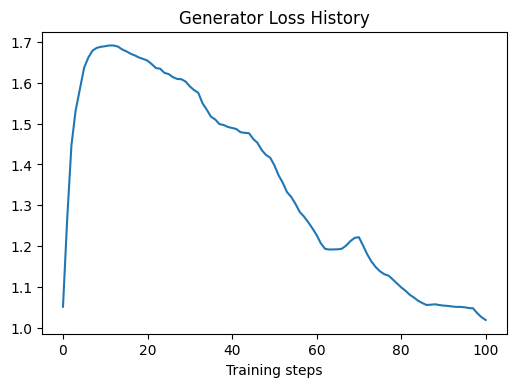

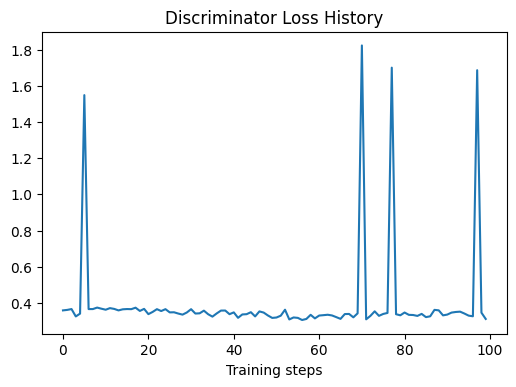

In [171]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare generated sequences between Random G and trained G

In [172]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(1000, G0,BATCH_SIZE, T)

In [173]:
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(1000, G, BATCH_SIZE, T)

In [174]:
tf.argmax(seqs_random_et, axis=2)

<tf.Tensor: shape=(1000, 21), dtype=int64, numpy=
array([[1, 2, 4, ..., 1, 4, 4],
       [1, 1, 4, ..., 1, 3, 5],
       [1, 5, 4, ..., 4, 0, 1],
       ...,
       [1, 4, 4, ..., 2, 0, 5],
       [1, 1, 2, ..., 2, 1, 2],
       [1, 1, 4, ..., 3, 1, 5]])>

In [176]:
tf.argmax(seqs_trained_et, axis=2)

InvalidArgumentError: Expected dimension in the range [-2, 2), but got 2 [Op:ArgMax]

## Save trained G and D weights

In [ ]:
if not os.path.exists(model_save_dir + '/G_run_2021-03-27'):
    os.makedirs(model_save_dir + '/G_run_2021-03-27')

G_save_path = model_save_dir + '/G_run_2021-03-27/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_2021-03-27'):
    os.makedirs(model_save_dir + '/D_run_2021-03-27')

D_save_path = model_save_dir + '/D_run_2021-03-27/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)